# Big Data Bowl Special Teams Plays' Excitement Ratings

In this notebook, I'll try to create an excitement metric that will have a pre-snap prediction of "expected excitement", an in-play excitement meter, and an overall excitement score for each special teams play. 

## Plan of Attack
1. Learn, clean, and manipulate the game, play, player, tracking, and scouting data
1. Split into test/train
1. Create a simple baseline metric to score each play in train data set
    1. This is probably just going to be game-level data
    1. We'll call this the overall excitement score
1. Train a model to predict overall excitement scores using only pre-snap (ie frame1) data
1. Use this model to predict excitement scores pre-snap on the test set
1. Analyze results to determine how good the model is
1. Create more complex excitement score based on player, team, game, play data
1. Rinse and repeat


## Imports and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

pd.options.display.float_format = '{:,.0f}'.format

## Useful Constants

In [2]:
field_height = 53.3

## Import and Inspect Game Data

In [3]:
games = pd.read_csv('data/games.csv')
games.head()


,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN


## Import and Inspect Player Data

In [4]:
players = pd.read_csv('data/players.csv')
players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


## Import and Inspect Play Data

In [5]:
plays = pd.read_csv('data/plays.csv')
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,"44,966",...,NaN,NaN,NaN,0,0,NaN,66,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,"45,603",...,UNSd,PHI 18,-15,0,0,NaN,56,5,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,"27,091",...,NaN,NaN,NaN,0,0,NaN,21,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,"37,267",...,NaN,NaN,NaN,0,3,NaN,64,30,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,"45,603",...,NaN,NaN,NaN,0,3,NaN,65,NaN,45,45


## Import and Inspect Scouting Data

In [6]:
scout = pd.read_csv('data/PFFScoutingData.csv')
scout.head()
# gunner_cols = [f'gunner{i}' for i in range(1, 5)]
# gunner_values = np.array([
#     np.pad(row, (0, 4 - len(row)), 'constant', constant_values=(np.nan,)) for row in scout['gunners'].str.split(';')])

# print(gunner_values)

# print(scout['gunners'].str.split(';').fillna(pd.Series(np.zeros(4))))


# pd.DataFrame(gunner_values, index=scout.index).head(20)
# scout[gunner_cols] = pd.DataFrame(gunner_values, index=scout.index)
# scout.head()


,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType
0,2018090600,37,NaN,NaN,NaN,4,D,R,R,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,PHI 23; PHI 27,NaN,NaN
1,2018090600,366,OK,1,2,4,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI 58,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4,D,R,R,C,C,ATL 83,ATL 22,ATL 27,8-0-2,NaN,NaN,ATL 17; ATL 22,NaN,NaN
4,2018090600,872,OK,1,2,4,N,C,L,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,2021010315,3683,NaN,NaN,NaN,4,D,L,L,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,SEA 28; SEA 99,NaN,NaN
19975,2021010315,3870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SF 20; SF 51,NaN,NaN
19976,2021010315,3886,NaN,NaN,NaN,4,D,L,L,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,SEA 28; SEA 99,NaN,NaN
19977,2021010315,4166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEA 37; SEA 54,NaN,NaN


## Import and Inspect 2018 Tracking Data

In [31]:
tracking  = pd.read_csv('data/tracking2018.csv')
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2018-12-30T21:25:32.200,41,29,4,1,0,130,128,None,"39,470",Justin Tucker,9,K,home,1,2018123000,36,right
1,2018-12-30T21:25:32.300,42,29,5,1,0,129,128,None,"39,470",Justin Tucker,9,K,home,2,2018123000,36,right
2,2018-12-30T21:25:32.400,42,29,5,1,0,124,128,None,"39,470",Justin Tucker,9,K,home,3,2018123000,36,right
3,2018-12-30T21:25:32.500,42,29,5,1,0,126,127,None,"39,470",Justin Tucker,9,K,home,4,2018123000,36,right
4,2018-12-30T21:25:32.600,43,28,5,1,0,132,125,None,"39,470",Justin Tucker,9,K,home,5,2018123000,36,right


## Enrich Tracking Data

In order to be consistent, let's standardize the play direction to always have the offense going from *left* to *right*. All we should need to do is for plays going to the *left*,
- flip x coordinate (`field_width - x`), 
- flip y coordinate (`field_height - y`), and 
- rotate the dir by 180 (`(360 - dir) % 360`). 

For plays going to the *right*, no conversion is needed. We'll store these new, or "standardized", values in `stdX`, `stdY`, and `stdDir`.

In [25]:
left_mask = tracking['playDirection'] == 'left'
right_mask = tracking['playDirection'] == 'right'
tracking.loc[left_mask, 'stdX'] = 120 - tracking.loc[left_mask, 'x']
tracking.loc[left_mask, 'stdY'] = field_height - tracking.loc[left_mask, 'y']
tracking.loc[left_mask, 'stdDir'] = (360 - tracking.loc[left_mask, 'dir']) % 360
tracking.loc[right_mask, 'stdX'] = tracking.loc[right_mask, 'x']
tracking.loc[right_mask, 'stdY'] = tracking.loc[right_mask, 'y']
tracking.loc[right_mask, 'stdDir'] = tracking.loc[right_mask, 'dir']
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,jerseyNumber,position,team,frameId,gameId,playId,playDirection,stdX,stdY,stdDir
0,2018-12-30T21:25:32.200,41,29,4,1,0,130,128,None,"39,470",...,9,K,home,1,2018123000,36,right,41,29,128
1,2018-12-30T21:25:32.300,42,29,5,1,0,129,128,None,"39,470",...,9,K,home,2,2018123000,36,right,42,29,128
2,2018-12-30T21:25:32.400,42,29,5,1,0,124,128,None,"39,470",...,9,K,home,3,2018123000,36,right,42,29,128
3,2018-12-30T21:25:32.500,42,29,5,1,0,126,127,None,"39,470",...,9,K,home,4,2018123000,36,right,42,29,127
4,2018-12-30T21:25:32.600,43,28,5,1,0,132,125,None,"39,470",...,9,K,home,5,2018123000,36,right,43,28,125


## Visualize Plays

One helpful thing when working with tracking data is to be able to see what each datapoint represents and how a frame looks. 
To do that, we'll create a function that creates a GIF of the requested play.
It'll take in a `game_id`, `play_id`, and Boolean flag `std` which says if the GIF should use the standardized coordinates or not. 

In [22]:
def animate_play(game_id, play_id, std=False):
    x_name = 'stdX' if std else 'x'
    y_name = 'stdY' if std else 'y'

    play = tracking.loc[(tracking['gameId'] == game_id) &( tracking['playId'] == play_id)]

    play['nflId'] = play['nflId'].fillna('football').astype(str)
    play['marker'] = play['team'].replace({'home': 'o', 'away': 's', 'football': 'd'})
    play['color'] = play['team'].replace({'home': 'r', 'away': 'blue', 'football': 'brown'})

    fig, ax = draw_field()
    markers = {
        f'{x["nflId"]}': ax.scatter(
            x[x_name], 
            x[y_name],
            s=10,
            marker=x['marker'],
            c=x['color'],
            zorder=3,
            edgecolors='black'
        ) for x in play.loc[play["frameId"] == 1].to_dict(orient='records')
    }

    def update(i):
        new_values = play.loc[play["frameId"] == i].set_index('nflId')[[x_name, y_name]].to_dict(orient='index')
        for k, v in markers.items():
            v.set_offsets([new_values[k][x_name], new_values[k][y_name]])
        return markers.values()

    ani = FuncAnimation(fig, update, frames=play['frameId'].unique(), blit=True)
    ani.save(f'game-{game_id}_play-{play_id}{"-std" if std else ""}.gif')

def draw_field():
    fig = plt.figure() 
    ax = plt.axes(xlim=(0, 120), ylim=(0, field_height)) 
    ax.set_facecolor('green')

    # Endzones
    rect = patches.Rectangle((0, 0), 10, field_height, linewidth=1, edgecolor='r', facecolor='red', zorder=1)
    ax.add_patch(rect)
    rect = patches.Rectangle((110, 0), 10, field_height, linewidth=1, edgecolor='blue', facecolor='blue', zorder=1)
    ax.add_patch(rect)

    # Yardlines
    for i in range(12):
        ax.plot((i*10, i*10), (0, field_height), color='w', zorder=1)
        if 1 < i < 11:
            label = (i-1) * 10
            ax.text(i*10 - 3, 5, f'{label}' if i < 6 else f'{100 - label}')

    plt.tick_params(
        axis='both', 
        which='both', 
        bottom=False, 
        top=False,       
        left=False,
        labelbottom=False,
        labelleft=False
    ) 
    return fig, ax


Let's try out this function with a play that's going to the *left* so we can see if the standardized coordinates worked as well. The firsth function call will create a file `game-2018090600_play-658-std.gif` and the second call will create `game-2018090600_play-658.gif`.

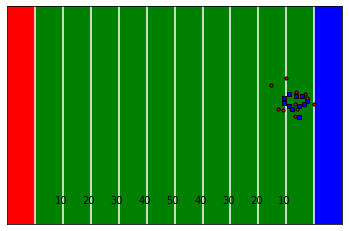

In [23]:
animate_play(2018090600, 658, True)
animate_play(2018090600, 658)